In [1]:
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

In [2]:
import torch
from torch.utils.data import DataLoader

import numpy as np
import tensorly as tl
import scipy.signal
import scipy.stats
import sklearn
import matplotlib.pyplot as plt
import copy

In [3]:
import sys
sys.path.append(r'/media/rich/Home_Linux_partition/github_repos')

%load_ext autoreload
%autoreload 2
import tensor_regression as tr
import tensor_regression.util
from tensor_regression import spectral_tensor_regression as STR
# from tensor_regression import standard_tensor_regression as STR

%load_ext autoreload
%autoreload 2
import basic_neural_processing_modules as bnpm
from basic_neural_processing_modules import torch_helpers
from basic_neural_processing_modules import h5_handling
from basic_neural_processing_modules import timeSeries
from basic_neural_processing_modules import similarity
from basic_neural_processing_modules import math_functions
from basic_neural_processing_modules import misc
from basic_neural_processing_modules import decomposition

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%matplotlib notebook

In [5]:
dir_data = r'/media/rich/bigSSD/for_Josh/'
fileName_X_data = r'positions_convDR_meanSub_s2pInd.h5'
fileName_y_data = r'neural_data.h5'
positions = h5_handling.simple_load(directory=dir_data, fileName=fileName_X_data)
neural_data = h5_handling.simple_load(directory=dir_data, fileName=fileName_y_data)

In [6]:
torch_helpers.show_cuda_devices()
DEVICE = tr.util.set_device(use_GPU=True, verbose=True)

1 device(s) found.
0 GeForce RTX 3090
GPU is enabled.


In [7]:
pos_array = positions['positions_convDR_meanSub_s2pInd']
print(f'pos_array.shape = {pos_array.shape}')

pos_array.shape = (108000, 2744)


<IPython.core.display.Javascript object>


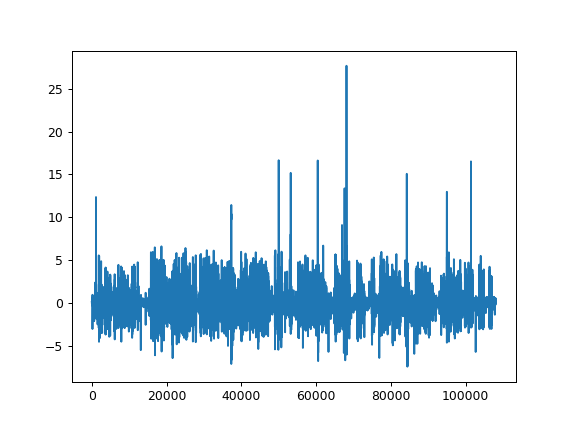

In [8]:
plt.figure()
plt.plot(pos_array[:,1200])

<IPython.core.display.Javascript object>


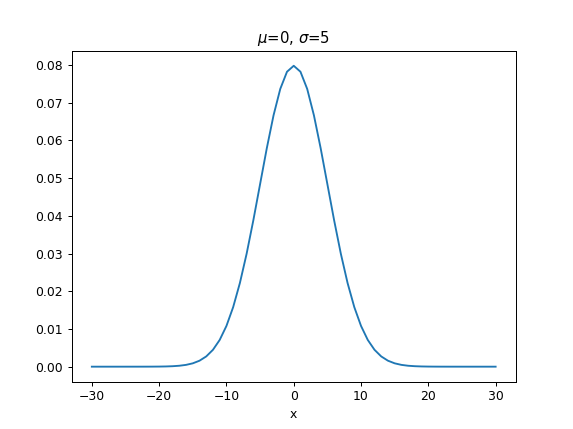

ThreadPool elapsed time : 0.25 s. Now unpacking list into array.
Calculated convolution. Total elapsed time: 0.41 seconds
neural_array.shape = (108000, 811)


In [9]:
ic = neural_data['is_cell']
good_ROIs = neural_data['good_ROIs']
spks = torch.tensor(neural_data['spks'][ic][good_ROIs]).T
dFoF = torch.tensor(neural_data['dFoF'][ic][good_ROIs]).T

gaussian_kernel , params_gaus = math_functions.gaussian(x=np.arange(-30,31,1),
                                                                  mu=0,
                                                                  sig=5,
                                                                  plot_pref=True)
spks_conv = timeSeries.convolve_along_axis(spks,
                                             gaussian_kernel,
                                             axis=0,
                                             mode='same',
                                             multicore_pref=True,
                                             verbose=True)

print(f'neural_array.shape = {spks_conv.shape}')

# win_range = [-120*3, -120*-1]
win_range = [-15, 15]

<IPython.core.display.Javascript object>


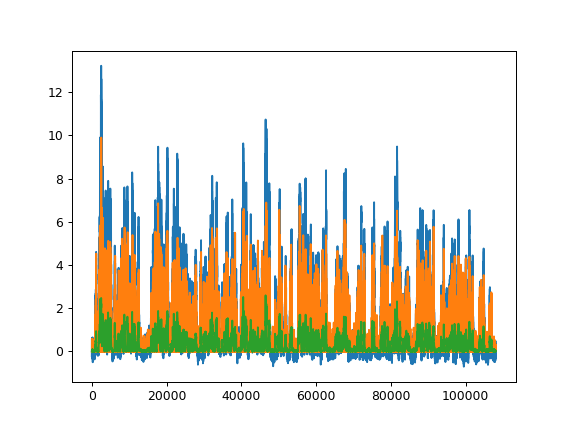

In [11]:
idx_toPlot = 35
plt.figure()
plt.plot(dFoF[:,idx_toPlot])
plt.plot(spks[:,idx_toPlot]/40)
plt.plot(spks_conv[:,idx_toPlot]/40)

In [12]:
pca_components , pca_scores , pca_EVR, stds = decomposition.simple_pca(pos_array, mean_sub=True, zscore=True)

<IPython.core.display.Javascript object>


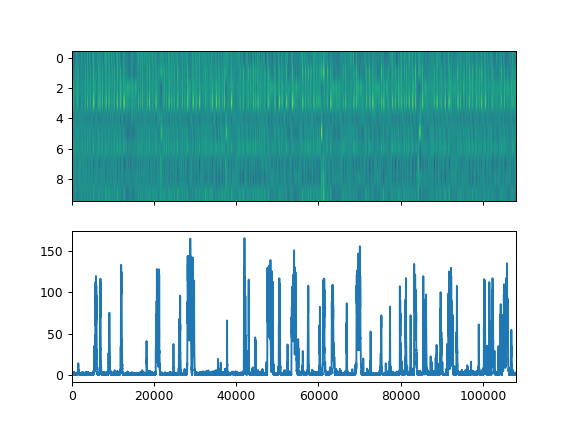

In [13]:
fig, axs = plt.subplots(2, sharex=True)
# axs[0].imshow(pca_scores[:,:10].T, aspect='auto');
axs[0].imshow((pca_scores[:,:10] / np.linalg.norm(pca_scores[:,:10],axis=1, keepdims=True)).T, aspect='auto');
axs[1].plot(spks_conv[:,0])

<IPython.core.display.Javascript object>


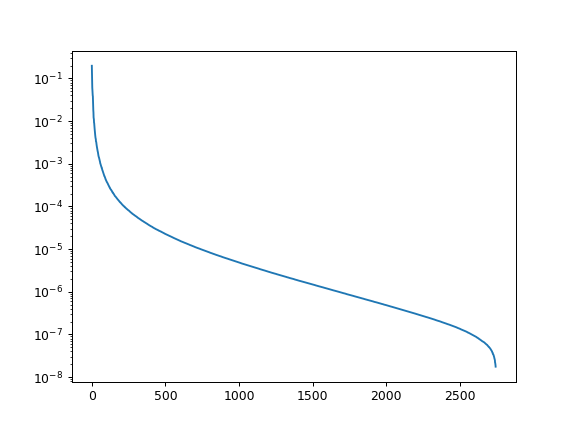

In [14]:
plt.figure()
plt.plot(pca_EVR)
plt.yscale('log')

In [167]:
win_len

1

In [235]:
win_len = int(6 * 30)
PCs_toUse = np.arange(0, 30)
# neuron_toUse = np.arange(0,800)
neuron_toUse = 10

In [236]:
## convert X time series into a time series of time window slices

input_array = pca_scores[:, PCs_toUse]
# input_array = pos_array - np.mean(pos_array, axis=0, keepdims=True)
# input_array = input_array[:,:600]
# input_array = pos_array - np.mean(pos_array, axis=0, keepdims=True)
# input_array = pca_scores * pca_EVR
# input_array = input_array - input_array.mean(0)
input_array = scipy.stats.zscore(input_array, axis=0)
norm_factor = 1
input_array = input_array*(1-norm_factor) + (input_array / np.linalg.norm(input_array, axis=1, keepdims=True))*(norm_factor)

# win_halfLen = [win_len//2 if win_len>1 else 0]
n_samples = input_array.shape[0]
slice_idx = np.arange(win_len//2, n_samples - win_len//2)
n_slices = len(slice_idx)
n_features = input_array.shape[1]

windowed_tensor = np.empty((n_slices, win_len, n_features), dtype=np.float32)
# windowed_tensor = np.empty((n_slices, 1, n_features), dtype=np.float32)
for ii, idx in enumerate(slice_idx):
#     ff_tensor[ii] = pos_array[idx:idx+win_len , :]
    windowed_tensor[ii] = input_array[idx-win_len//2:(idx+(win_len-1)//2) +1 , :]
#     windowed_tensor[ii] = input_array[idx:idx+1 , :]

X = torch.tensor(windowed_tensor[:,:,:], dtype=torch.float32)
# X = torch.tensor(windowed_tensor[:50000,:,:2744//3], dtype=torch.complex64)
# X = X / torch.norm(X)
# X = X*100
# X = X - torch.mean(X, dim=1)[:,None,...]




y = torch.tensor(spks_conv[:, neuron_toUse], dtype=torch.float32)[slice_idx][:]
y = y - torch.mean(y, dim=0)
y = scipy.stats.zscore(y, axis=0)
y = torch.roll(y, 0, dims=0)
# y = y / torch.norm(y)
# y = y*40000

print(f'X size: {misc.estimate_size_of_float_array(input_shape=X.shape, bitsize=32)/1000000000} GB')
print(f'X tensor shape:  {X.shape}')
print('')
print(f'y size: {misc.estimate_size_of_float_array(input_shape=y.shape, bitsize=32)/1000000000} GB')
print(f'y tensor shape:  {y.shape}')

X size: 2.328912 GB
X tensor shape:  torch.Size([107820, 180, 30])

y size: 0.00043128 GB
y tensor shape:  torch.Size([107820])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


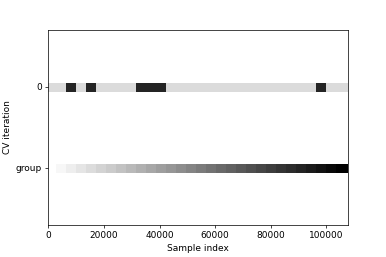

In [237]:
%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import cross_validation

from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit,
                                 StratifiedKFold, GroupShuffleSplit,
                                 GroupKFold, StratifiedShuffleSplit)
Fs = 30
group_len = 60*2 * Fs # seconds * Fs
n_splits = 1
test_size = 0.2
groups = np.arange(X.shape[0])//group_len
n_groups = np.max(groups)
cv = GroupShuffleSplit(n_splits, test_size=test_size)
cv_idx_all = cross_validation.make_cv_indices(cv,
                                        groups,
                                        lw=10,
                                        plot_pref=True)

In [258]:
%matplotlib inline
import torch
from tqdm.notebook import tqdm, trange

DEVICE = tr.util.set_device(use_GPU=True)

# h_vals = np.logspace(-50, 2, num=30, endpoint=True, base=10.0)
# h_vals = np.int64(np.linspace(1, 300, num=30, endpoint=True))
# h_vals = np.logspace(-5.5, -3.5, num=20, endpoint=True)
# h_vals = np.array([1e-1, 5e-2, 2e-2, 1e-2, 0.5e-2, 0.2e-2, 0.1e-2, 0.05e-2])
# h_vals = np.array([1e1, 5e0, 2e0, 1e0, 5e-1, 2e-1, 1e-1, 5e-2, 2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 5e-4, 2e-4, 0])
# h_vals = np.array([2e-1, 1e-1, 5e-2, 2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 5e-4, 2e-4, 0])
# h_vals = np.array([0.002, 0.004, 0.006, 0.008, 0.01])
h_vals = np.array([0.02])
# h_vals = np.array([0.001])
# h_vals = np.array([0])


loss_all = []
params_all = []
EV_all = []
R_all = []
for ii, val in enumerate(h_vals):
    for cv_iter, cv_idx in tqdm(enumerate(cv_idx_all)):
        X_train = X[cv_idx[0]]
        y_train = y[cv_idx[0]]
        X_test = X[cv_idx[1]]
        y_test = y[cv_idx[1]]
        
        import gc
        if 'cpmlr' in globals():
            print('deleting cpmlr')
            del cpmlr
            torch.cuda.empty_cache()
            gc.collect()
            torch.cuda.empty_cache()
            gc.collect()
        torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        gc.collect()


        print(f'hyperparameter val: {val}')
#         dataloader, dataset, sampler = tr.util.make_WindowedDataloader(X_train, y_train, win_range=win_range, batch_size=60000, drop_last=True)

        cpmlr = STR.CP_linear_regression(
                                         X_train.shape,
                                         y_train.shape,
                                         rank_normal=1,
                                         rank_spectral=0,
                                         non_negative=[False, False, True],
                                         weights=None,
                                         Bcp_init=None,
                                             Bcp_init_scale=1,
#                                              Bcp_init_scale=0.005,
#                                          Bcp_init_scale=0.02,
                                         n_complex_dim=1,
                                         device=DEVICE,
                                         softplus_kwargs={
                                             'beta': 50,
                                             'threshold':1}
                                         )
        
#         cpmlr = STR.CP_linear_regression(
#                                          X_train.shape,
# #                                          y_train.shape,
#                                          rank=8,
#                                          non_negative=[False, False],
#                                          weights=None,
#                                          Bcp_init=None,
#                                              Bcp_init_scale=1,
# #                                              Bcp_init_scale=0.005,
# #                                          Bcp_init_scale=0.02,
# #                                          n_complex_dim=1,
#                                          device=DEVICE,
#                                          softplus_kwargs={
#                                              'beta': 50,
#                                              'threshold':1}
#                                          )


        # tic = time.time()

        cpmlr.fit(X_train.to(DEVICE), y_train.to(DEVICE),
            lambda_L2=h_vals[ii], 
                    max_iter=200, 
                    tol=1e-50, 
                    patience=3,
                    verbose=2,
                    running_loss_logging_interval=1,
                    LBFGS_kwargs={
                        'lr' : 100, 
                        'max_iter' : 20, 
                        'max_eval' : None, 
                        'tolerance_grad' : 1e-07, 
                        'tolerance_change' : 1e-09, 
                        'history_size' : 100, 
                        'line_search_fn' : "strong_wolfe"
                    }
                 )

#         cpmlr.fit_Adam( X_train.to(DEVICE), y_train.to(DEVICE),
#                         lambda_L2=h_vals[ii], 
#                         max_iter=2000, 
#                         tol=1e-50, 
#                         patience=10,
#                         verbose=2,
# #                         running_loss_logging_interval=1,
#                     Adam_kwargs={
#                             'lr' : 0.01, 
#     #                             'betas' : (0.9, 0.999), 
#     #                             'eps' : 1e-08, 
#     #                             'weight_decay' : 0, 
#                             'amsgrad' : True
#                         }
#                     )




#         cpmlr.fit_batch_Adam(dataloader,
#                     lambda_L2=h_vals[ii], 
#                     max_iter=4000, 
#                     tol=1e-8, 
#                     patience=100,
#                     n_iter_inner=10,
#                     verbose=2,
#                     Adam_kwargs={
#                             'lr' : 0.0005, 
#     #                             'betas' : (0.9, 0.999), 
#     #                             'eps' : 1e-08, 
#     #                             'weight_decay' : 0, 
#                             'amsgrad' : True
#                         }
#              )
    
#         cpmlr.fit_batch_LBFGS(dataloader,
#                     lambda_L2=h_vals[ii], 
#                     max_iter=4000, 
#                     tol=1e-8, 
#                     patience=100,
#                     verbose=2,
#                     n_iter_inner=3,
#                     LBFGS_kwargs={
#                                     'lr' : 1, 
#                                     'max_iter' : 20, 
#                                     'max_eval' : None, 
#                                     'tolerance_grad' : 1e-07, 
#                                     'tolerance_change' : 1e-09, 
#                                     'history_size' : 100, 
#                                     'line_search_fn' : "strong_wolfe"
#                                 }
#              )

        # print(time.time() - tic)
        final_loss = cpmlr.loss_running[-1]
        print(f'loss: {final_loss}')

        loss_all.append(final_loss)
#         params_all.append(cpmlr.get_params())

        y_pred = cpmlr.predict(X_train)
        EV_train = sklearn.metrics.explained_variance_score(y_train, y_pred)
#         R_train = similarity.pairwise_similarity(y_train.numpy(), y_pred, method='pearson')
        R_train = np.diag(similarity.pairwise_similarity(y_train.numpy(), y_pred, method='pearson'))
        y_pred = cpmlr.predict(X_test)
        EV_test = sklearn.metrics.explained_variance_score(y_test, y_pred)
        R_test = np.diag(similarity.pairwise_similarity(y_test.numpy(), y_pred, method='pearson'))
        print(f'EV_train / EV_test: {EV_train.mean()} / {EV_test.mean()}  ;  R_train / R_test: {R_train.mean()} / {R_test.mean()}')
        
        EV_all.append([EV_train, EV_test])
        R_all.append([R_train, R_test])

GPU is enabled.


0it [00:00, ?it/s]

deleting cpmlr
hyperparameter val: 0.02
Iteration: 0, Loss: 0.9832667112350464  ;  Variance ratio (y_hat / y_true): 0.03617743857677519
Iteration: 1, Loss: 0.8383757472038269  ;  Variance ratio (y_hat / y_true): 0.10853951171843003
Iteration: 2, Loss: 0.8003831505775452  ;  Variance ratio (y_hat / y_true): 0.1432323086224516
Iteration: 3, Loss: 0.7931739091873169  ;  Variance ratio (y_hat / y_true): 0.14271803207576614
Iteration: 4, Loss: 0.7924900054931641  ;  Variance ratio (y_hat / y_true): 0.1456481209463824
Iteration: 5, Loss: 0.7924471497535706  ;  Variance ratio (y_hat / y_true): 0.1458995562767716
Iteration: 6, Loss: 0.7924471497535706  ;  Variance ratio (y_hat / y_true): 0.1458995562767716
Iteration: 7, Loss: 0.7924471497535706  ;  Variance ratio (y_hat / y_true): 0.1458995562767716
Iteration: 8, Loss: 0.7924471497535706  ;  Variance ratio (y_hat / y_true): 0.1458995562767716
Convergence reached
loss: 0.7924471497535706
EV_train / EV_test: 0.15994060039520264 / 0.0449261665344

<IPython.core.display.Javascript object>


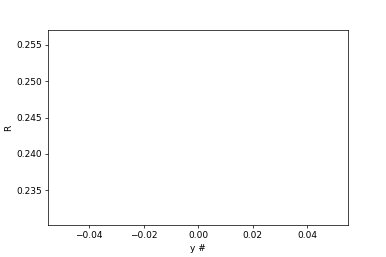

Text(0, 0.5, 'R')

In [239]:
%matplotlib notebook

plt.figure()
plt.plot(R_all[-1][1])
plt.xlabel('y #')
plt.ylabel('R')

<IPython.core.display.Javascript object>


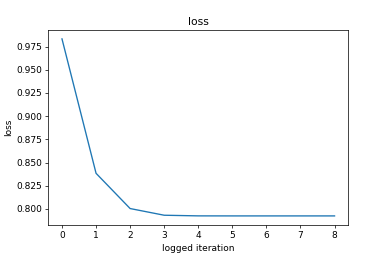

<IPython.core.display.Javascript object>


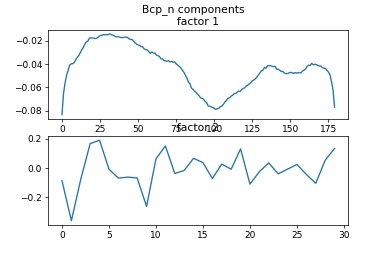

In [259]:
%matplotlib notebook
cpmlr.plot_outputs()

In [413]:
test = tl.cp_tensor.cp_to_tensor((cpmlr.weights[3:], list(STR.non_neg_fn(
                                                    [cpmlr.Bcp_n[ii][:,:,0] for ii in range(len(cpmlr.Bcp_n))],
                                                    cpmlr.non_negative,
                                                    cpmlr.softplus_kwargs))
                                                     ))

<IPython.core.display.Javascript object>


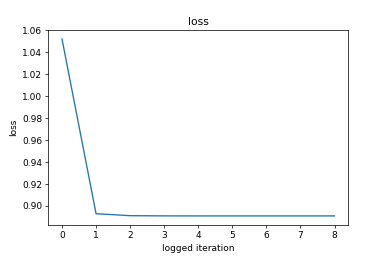

<IPython.core.display.Javascript object>


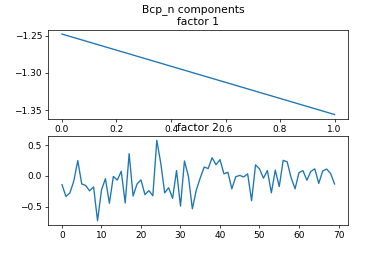

In [38]:
%matplotlib notebook
cpmlr.plot_outputs()

In [111]:
(7*7*8*9*7*2*800)*20/(60*60)

219520.0

R = 0.2928231358528137


<IPython.core.display.Javascript object>


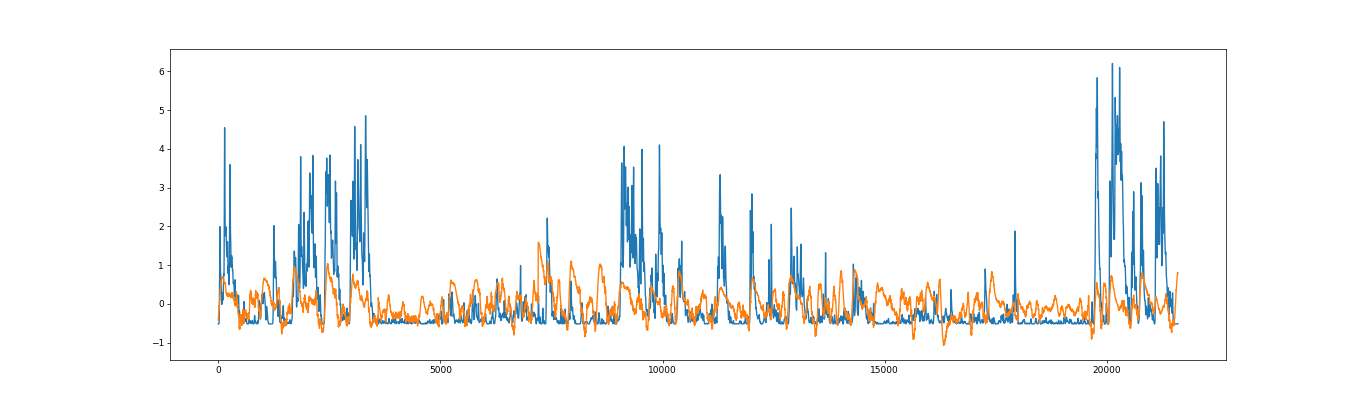

<IPython.core.display.Javascript object>


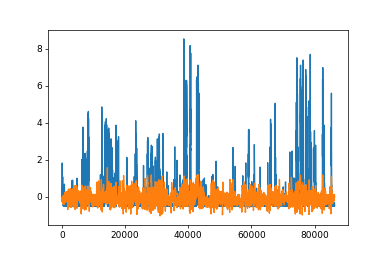

In [222]:
%matplotlib notebook

idx_toPlot = None

y_hat_test = cpmlr.predict(X_test.cpu())
y_hat_train = cpmlr.predict(X_train.cpu())

print(f'R = {similarity.pairwise_similarity(y_hat_test[:,idx_toPlot].squeeze(), y_test[:,idx_toPlot].cpu().detach().numpy().squeeze())[0][0]}')

plt.figure()
plt.plot(y_test[:,idx_toPlot])
plt.plot(y_hat_test[:,idx_toPlot])

plt.figure()
plt.plot(y_train[:,idx_toPlot])
plt.plot(y_hat_train[:,idx_toPlot])

In [33]:
path_nwb = r'/media/rich/bigSSD/analysis_data/mouse 2_6/20210417/FR_run2_20210902/data/session.nwb'

from face_rhythm.util import helpers
helpers.dump_nwb(path_nwb)

import pynwb
from pynwb import NWBHDF5IO

with pynwb.NWBHDF5IO(path_nwb, mode='r') as io:
    file = io.read()
    pts_spaced_convDR = file.processing['Face Rhythm']['Optic Flow']['pts_spaced_convDR'].data[:]

CQT
     Sxx_allPixels:    (1372, 30, 27288, 2)   ,  float32   ,   8.985393 GB
     Sxx_allPixels_norm:    (1372, 30, 27288, 2)   ,  float32   ,   8.985393 GB
     Sxx_allPixels_normFactor:    (27288, 2)   ,  float32   ,   0.000218 GB
     Sxx_xAxis:    (436601,)   ,  float64   ,   0.003493 GB
     freq_idx_toUse:    (30,)   ,  bool   ,   0.0 GB
     freqs_Sxx_all:    (30,)   ,  float64   ,   0.0 GB
     freqs_Sxx_toUse:    (30,)   ,  float64   ,   0.0 GB
Optic Flow
     color_tuples:    (309285, 3)   ,  float64   ,   0.007423 GB
     displacements:    (3102, 2, 436601)   ,  float64   ,   21.669381 GB
     pointInds_toUse:    (3102, 1, 2)   ,  float32   ,   2.5e-05 GB
     positions_cleanup:    (3102, 2, 436601)   ,  float64   ,   21.669381 GB
     positions_cleanup_absolute:    (3102, 2, 436601)   ,  float64   ,   21.669381 GB
     positions_convDR_absolute:    (1372, 2, 436601)   ,  float64   ,   9.584265 GB
     positions_convDR_meanSub:    (1372, 2, 436601)   ,  float64   ,   9.584

In [34]:
def unmix_pcs(pca_components, weight_vecs):
    """
    Transforms weight_vecs into pca_components space
    RH 2021
    """
    if weight_vecs.ndim == 1:
        weight_vecs = weight_vecs[:,None]
    
    mixing_vecs = np.zeros((pca_components.shape[0], weight_vecs.shape[1]))
    mixing_vecs[:weight_vecs.shape[0],:] = weight_vecs

    return torch.tensor(pca_components).T @ mixing_vecs

<IPython.core.display.Javascript object>


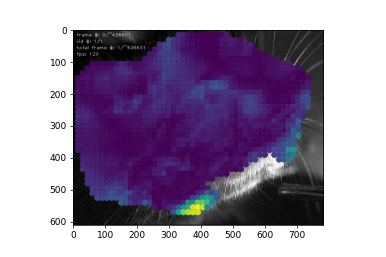

<IPython.core.display.Javascript object>


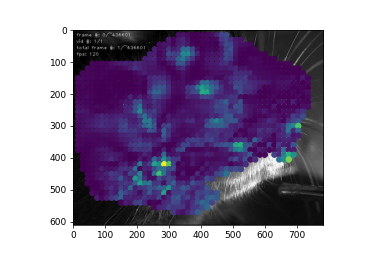

<IPython.core.display.Javascript object>


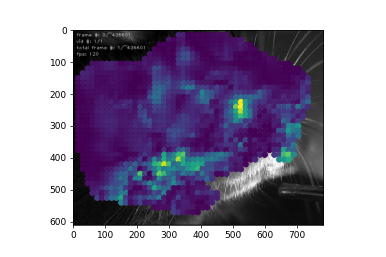

<IPython.core.display.Javascript object>


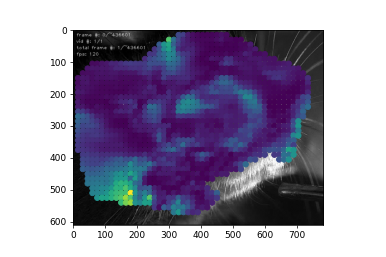

<IPython.core.display.Javascript object>


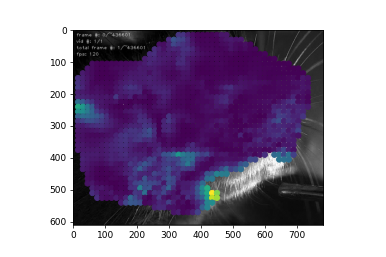

<IPython.core.display.Javascript object>


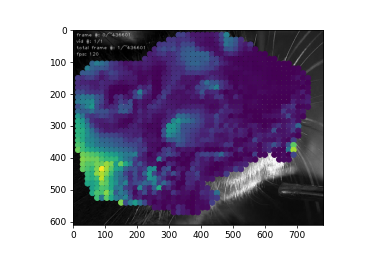

In [387]:
import imageio

# c_face_dots = cpmlr.Bcp[1].detach().cpu().numpy()
# c_face_dots = unmix_pcs(pca_components, torch.tensor([0,0,0,0,0,0,0,0,0,0,1]))
# c_face_dots = unmix_pcs(pca_components, cpmlr.Bcp[1][:,:].cpu().detach().numpy().squeeze())
c_face_dots = unmix_pcs(pca_components, torch.hstack([cpmlr.Bcp_n[1][:,:,0], cpmlr.Bcp_c[1][:,:,0]]).cpu().detach().numpy().squeeze())
# c_face_dots = unmix_pcs(pca_components, torch.hstack([cpmlr.Bcp_n[1][:,:,0], cpmlr.Bcp_c[1][:,:,0]]).cpu().detach().numpy().squeeze() * np.var(pca_scores, axis=0)[:cpmlr.Bcp_n[1].shape[0], None])
# c_face_dots = unmix_pcs(pca_components, torch.sum(torch.vstack([cpmlr.Bcp_n[1][:,:,0][None,:], cpmlr.Bcp_c[1][:,:,0][None,:]]), dim=0).cpu().detach().numpy().squeeze())
c_face_dots = c_face_dots.reshape(c_face_dots.shape[0]//2, 2, c_face_dots.shape[1])
cfd_mag = np.linalg.norm(c_face_dots, axis=1)

path_mouse_movie = r'/media/rich/bigSSD/analysis_data/mouse 2_6/20210417/FR_run2_20210902/viz/just_mouse.avi'

reader = imageio.get_reader(path_mouse_movie)
for i, im in enumerate(reader):
    im_mouse = im
    break
for ii in range(cfd_mag.shape[1]):
    plt.figure()
    plt.imshow(im_mouse)
    plt.scatter(pts_spaced_convDR[:,0,0], pts_spaced_convDR[:,0,1], c=cfd_mag[:,ii]**2) # / np.mean(stds.reshape(len(stds)//2, 2), axis=1))